
$$
\newcommand{\xb}{\boldsymbol{x}}
\newcommand{\wb}{\boldsymbol{w}}
\newcommand{\pb}{\boldsymbol{p}}
\newcommand{\1}{\mathbb{1}}
$$

# Logistic Regression with NumPy

Version 2

**I would suggest using this version of the notebook. However, if you'd like to, you can continue using version 1; just be sure to pay attention to the changes (as discussed in the lab).**

This this lab you'll develop a simple classifier using binary logistic regression to classify images of digits as either 4 or 9. All images, both during training and at test time, will be either a 4 or a 9.

Your implementation will focus on concepts: whenever possible, we will stick with clear notations and one-to-one mapping with equations, rather than manipulating those equations and/or the computations for efficiency and numerical stability.

In [1]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

    100% |████████████████████████████████| 592.3MB 53.6MB/s 
    100% |████████████████████████████████| 51kB 2.8MB/s 
    100% |████████████████████████████████| 5.9MB 224kB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Numerically stable version of the sigmoid function
# sigmoid(x) = 1 / (1 + exp(-x))
from scipy.special import expit

import torchvision

from pathlib import Path
HOME = Path.home()
MNIST_PATH = HOME / 'data' / 'mnist'

NUM_CLASSES = 10
CHANNELS = 1
HEIGHT = 28
WIDTH = 28

In [3]:
# We're going to load the official train set and never touch
# the true test set in these experiments, which consists of 10,000
# separate examples. We'll instead split our training set into
# a set for training and a set for validation.
official_mnist_train = torchvision.datasets.MNIST(str(MNIST_PATH), train=True, download=True)
official_train_images = official_mnist_train.train_data.numpy().astype(np.float)
official_train_labels = official_mnist_train.train_labels.numpy().astype(np.int)

Processing...
Done!


In [4]:
print(official_train_images.shape)
print(official_train_labels.shape)

(60000, 28, 28)
(60000,)


First let's grab only the 4s and 9s, which will end up forming our binary classification problem.

In [5]:
mask_4_9 = (official_train_labels == 4) | (official_train_labels == 9)
images_4_9 = official_train_images[mask_4_9]
labels_4_9 = (official_train_labels[mask_4_9] == 9).astype(np.int)
print(images_4_9.shape, labels_4_9.shape)

(11791, 28, 28) (11791,)


**Write code that concatenates the first 10 images together, horizontally. Visualize the result (using `plt.imshow`), and print the first 10 labels that correspond to these images. Make sure the labels are binary: 0 if the image is a 4 and 1 if the image is a 9.**

[0 1 0 1 0 1 0 1 1 1]


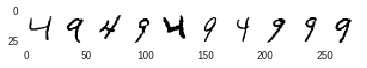

In [6]:
example_images = np.concatenate(images_4_9[:10], axis=1)
example_labels = labels_4_9[:10]
print(example_labels)
plt.imshow(example_images)
plt.grid(False)

**Use `np.split` to split `images_4_9` into `train_images` and `val_images`, and `labels_4_9` into `train_labels` and `val_labels`. Use 10000 images for training and the rest for validation.**

In [0]:
train_images, val_images = np.split(images_4_9, [10000])
train_labels, val_labels = np.split(labels_4_9, [10000])

**Print the shapes of `train_images`, `train_labels`, `val_images`, and `val_labels`. Make sure that there are 10000 images for training and 1791 for validation.**

In [8]:
print(train_images.shape, train_labels.shape)
print(val_images.shape, val_labels.shape)

(10000, 28, 28) (10000,)
(1791, 28, 28) (1791,)


**Complete `normalize_stats_image_by_image` so that images are normalized on a *per image basis*.**

In [0]:
def normalize_stats_image_by_image(images):
  mean = images.mean(axis=(1,2), keepdims=True)
  stdev = images.std(axis=(1,2), keepdims=True)
  return (images - mean) / stdev

**Use `normalize_stats_image_by_image` to replace the training and validation images with their normalized versions.**

In [0]:
train_images = normalize_stats_image_by_image(train_images)
val_images = normalize_stats_image_by_image(val_images)

**Print the mean and standard deviation *of the first 3 images* of the training set, and do the same for the validation set. Make sure that all 3 means are very close to 0 and that all 3 standard deviations are very close to 1.**

In [11]:
print(train_images[:3].mean(axis=(1, 2)))
print(train_images[:3].std(axis=(1, 2)))
print(val_images[:3].mean(axis=(1, 2)))
print(val_images[:3].std(axis=(1, 2)))

[9.06304510e-18 1.81260902e-17 4.07837029e-17]
[1. 1. 1.]
[-9.06304510e-18  0.00000000e+00  1.17819586e-16]
[1. 1. 1.]


**Concatenate 10 train images and 10 validation images together into a single array and visualize the result using `plt.imshow`.**

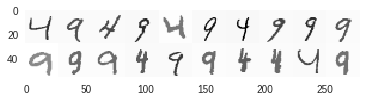

In [12]:
some_train_images = np.concatenate(train_images[:10], axis=1)
some_val_images = np.concatenate(val_images[:10], axis=1)
some_train_and_val_images = np.concatenate([some_train_images, some_val_images], axis=0)
plt.imshow(some_train_and_val_images)
plt.grid(False)

**Form `train_vectors` and `val_vectors` by reshaping the images into *vectors*. That is, flatten each image so that instead of being 28 x 28 matrix it's a vector with 28 * 28 dimensions.**

In [0]:
train_vectors = train_images.reshape(-1, HEIGHT * WIDTH)
val_vectors = val_images.reshape(-1, HEIGHT * WIDTH)

For any particular example $\xb$, we're modeling $p(y \mid \xb)$ as

$$
\hat{p}(y = 0) = \sigma(\wb^T\xb), \qquad
\hat{p}(y = 1) = 1 - \hat{p}(y = 0)
$$

where here the label $y = 0$ specifies that our image is a 4, and the label $y = 1$ specifies that our image is a 9.

**Complete the `model` function below so that it corresponds to simple logistic regression. You can use `expit`, a numerically-stable version of the sigmoid function.**

In [0]:
def model(X, w):
  """Binary logistic regression.
  
  Hint: You should vectorize all operations, as discussed in class.
  In other words, you should not use any loops, as if you your
  code will likely be tremendously slow.
  
  Hint: Think about the shape of X, and for the moment pretend that
  w is a column vector (rather than a 1-D array). Our goal is to
  compute w'x for every example x in X. Does this correspond to
  w' @ X or X @ w?
  
  Args:
    X: A float NumPy array with shape
      [num_examples, num_features].
    w: A float NumPy array with shape [num_features].
    
  Returns:
    A float NumPy array p_hat of probabilities with shape
      [num_examples, 2]. For example i, we have
      p_hat[i, :] = [sigmoid(w'x), 1 - sigmoid(w'x)]
  """
  p_hat0 = expit(X@w.reshape((-1,1)))
  p_hat1 = 1 - expit(X@w.reshape((-1,1)))
  p_hat = np.concatenate((p_hat0, p_hat1), axis = 1)
  return p_hat

The loss for a *single* example is
$$
\begin{align}
l(\hat{\pb}, \pb)
&= -\sum_i p_i \log \hat{p}_i \\
&= - \1(y = 0) \log \sigma(\wb^T\xb) - \1(y = 1) \log (1 - \sigma(\wb^T\xb))
\end{align}
$$

**Complete the `binary_cross_entropy` function below.**

In [0]:
def binary_cross_entropy(p_hat, y):
  """Cross entropy loss.
  
  PAY ATTENTION TO THE SHAPES OF THE ARGUMENTS, AND
  WHAT THESE ARGUMENTS REPRESENT.
  
  Hint: You can compute cross entropy on a per-example basis,
  and then just compute the mean of the resulting values.
  
  Hint: Think of the indicator function above in terms of masks in
  NumPy.
  
  Args:
    p_hat: A float NumPy array with shape [num_examples, 2].
    y: An int NumPy array with shape [num_examples].
  
  Returns:
    A float: the cross entropy averaged across all of the examples.
  """
  loss = np.zeros((y.shape[0], ))
  loss[y==0] = -1 * np.log(p_hat[y == 0][:,0])
  loss[y==1] = -1 * np.log(p_hat[y == 1][:,1])
  return np.mean(loss)

The *Jacobian* for a *single* example is

$$\frac{\partial l}{\partial \wb} = -\1(y = 0) \left(1 - \sigma(\wb^T\xb)\right) \xb^T + \1(y = 1) \sigma(\wb^T\xb) \xb^T$$

**Complete the `binary_cross_entropy_grad` function below.**

In [0]:
def binary_cross_entropy_grad(X, w, y):
  """Gradients for binary logistic regression.
  
  Hint: You can compute the gradient on a per-example basis,
  and then just average these gradients over all examples.
  (This follows from the fact that the gradient of a sum
  is the sum of the gradients; in other words, the derivative
  operator 'pushes through' summations.)
  
  Args:
    X: A float NumPy array with shape
      [num_examples, num_features].
    w: A float NumPy array with shape [num_features].
    y: An int NumPy array with shape [num_examples].
  
  Returns:
    A float NumPy array w_grad with shape [num_features]. This is We have
    w_grad[i] = dl/dw[i], where l is the cross entropy between
    our empirical distribution and the distribution from our model.
    The resulting gradient should be averaged over all examples.
  """
  p_hat = model(X, w)
  grad = np.zeros((w.shape[0], y.shape[0]))
  grad[:,y==0] = (-1 * p_hat[y == 0][:,1]) * X[y==0].T 
  grad[:,y==1] = (1 * p_hat[y == 1][:,0] * X[y==1].T)
  return np.mean(grad, axis = 1)

**Complete the `error_rate` function below.**

In [0]:
def error_rate(p_hat, y):
  """Error rate.
  
  PAY ATTENTION TO THE SHAPES OF THE ARGUMENTS, AND
  WHAT THESE ARGUMENTS REPRESENT.
  
  Args:
    p_hat: A float NumPy array with shape [num_examples, 2].
    y: An int NumPy array with shape [num_examples].
  
  Returns:
    A float between 0.0 and 1.0.
  """
  y_hat = np.argmax(p_hat, axis=1)
  #print(y_hat)
  error_rate = 1 - (np.sum(y_hat == y)/y.size)
  return error_rate

**Run the following code block to define the function `random_train_batch`. (We've written it for you.)**![alt text](https://)

In [0]:
def random_train_batch(batch_size):
  random_ind = np.random.choice(train_vectors.shape[0], size=batch_size, replace=False)
  return train_vectors[random_ind], train_labels[random_ind]

**Run the following code block to initializes your weights `w`, and to define your batch size, learning rate, and other parameters.**

(We'll begin with a batch size of 100, a learning rate of 1e-5, and we'll take 10000 optimization steps, logging our performance every 10 steps.)

In [0]:
w = 0.01 * np.random.randn(HEIGHT * WIDTH)
batch_size = 100
learning_rate = 1e-3
num_steps = 10000
num_steps_per_log = 10

**Run the following block of code to run all of our validation examples through our model, and to visualize the first validation example along with the prediction of our model. (Before training, we expect it to be garbage.)**

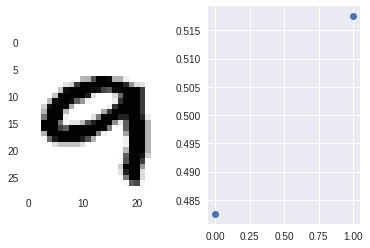

In [57]:
X_val = val_vectors
p_hat_val = model(X_val, w)

plt.subplot(1, 2, 1)
plt.imshow(X_val[0].reshape(HEIGHT, WIDTH))
plt.grid(False)
plt.subplot(1, 2, 2)
plt.plot(p_hat_val[0], 'o')

**Complete the following block of code by filling in the TODOs.**

In [0]:
X_val, y_val = val_vectors, val_labels
log_names = ['step', 'time', 'train loss', 'val loss', 'train error rate', 'val error rate']
logs = []
best_val_error_rate = 1.0
best_w = w
start_time = time.time()
for step in range(num_steps):
  
  X_train, y_train = random_train_batch(batch_size)
  
  if step % num_steps_per_log == 0:
    
    t = time.time() - start_time
    
    # TODO: Complete this section.
    p_hat_train = model(X_train, w)
    train_loss = binary_cross_entropy(p_hat_train, y_train)
    train_error_rate = error_rate(p_hat_train, y_train)
    
    # TODO: Complete this section.
    p_hat_val = model(X_val, w)
    val_loss = binary_cross_entropy(p_hat_val, y_val)
    val_error_rate = error_rate(p_hat_val, y_val)
    
    if val_error_rate < best_val_error_rate:
      best_val_error_rate = val_error_rate
      best_w = w
    
    logs.append([step, t, train_loss, val_loss, train_error_rate, val_error_rate])
  
  w_grad = binary_cross_entropy_grad(X_train, w ,y_train) # TODO: Fill in this line.
  w -= learning_rate * w_grad

Best val error rate: 0.03


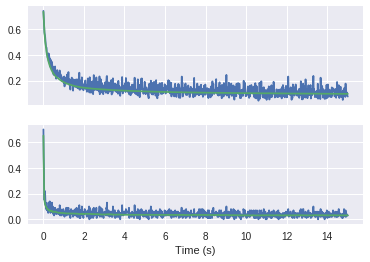

In [61]:
_, x, y11, y12, y21, y22 = zip(*logs)
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(x, y11, x, y12)
ax[1].plot(x, y21, x, y22)
plt.xlabel('Time (s)')
print('Best val error rate: {:.2f}'.format(best_val_error_rate))

**In the following Markdown Cell, answer:**

**We took 10000 optimization steps, each with a batch size of 100 and a learning rate of 1e-5. Did the validation loss stabilize? What was the best validation error rate that you achieved?**

Val Loss does not really stabilize until after 13 seconds. The best validation error rate achieved was 0.10.

**Repeat the above experiment, but with a learning rate of 1e-3.**

**Then, in the following Markdown Cell, answer:**

**We took 10000 optimization steps, each with a batch size of 100 and a learning rate of 1e-3. Did the validation loss stabilize? What was the best validation error rate that you achieved? Is there any evidence of overfitting here?**

The validation loss does stabilize after 1 second. The best validation error rate achieved was 0.03. It does not appear to be overfitting here as the validation performance is higher than the training performance. The validation loss seems to be lower than the training loss.

**Run the following block of code to run all of our validation examples through our model, and to visualize the first validation example along with the prediction of our model.**

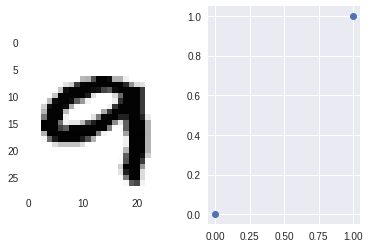

In [62]:
X_val = val_vectors
p_hat_val = model(X_val, w)

plt.subplot(1, 2, 1)
plt.imshow(X_val[0].reshape(HEIGHT, WIDTH))
plt.grid(False)
plt.subplot(1, 2, 2)
plt.plot(p_hat_val[0], 'o')

**Write code to visualize our parameters, `best_w`, as a 28 x 28 image.**

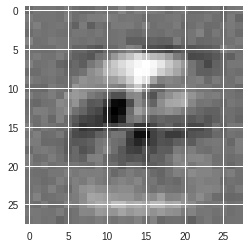

In [65]:
plt.imshow(w.reshape((28,28)))

**In the following Markdown Cell, answer:**

**Can you explain what you're seeing in this visualization of our weights? For example, what do you think the weights with large values (bright white in the image) correspond to?**

Wow this is pretty cool. We see the visualization of our weights with a bright white portion in the (10 to 15, 5 to 10) portion of the weights. The lowest weights are black and the highest weights are white. From far, it looks like a representation of the digit 4 and 9. In addition, the bright white portion coordinates seem to be the difference between 4 and 9. Not sure if that is significant.